---
# Decision trees

Los árboles de decisión son uno de los métodos más efectivos para los problemas de clasificación. Para introducirlos, necesitamos familiarizarnos con la siguiente terminología:

* Raíz: Nodo principal del que parte la primera iteración.
* Partición: Proceso de dividir un nodo *padre* en dos o más *hijos*.
* Nodo de decisión: Nodo a partir del cual se descompone el árbol.
* Nodo terminal: Nodo límite que no da lugar a más iteraciones.
* Rama: Sub-árbol del principal.

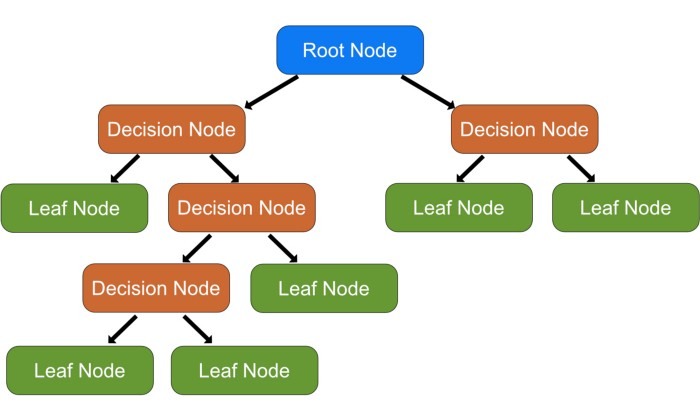

Entendemos por tanto que el núcleo fundamental de este algoritmo son los nodos, y la información inherente a ellos. Debido a esta razón, dichos objetos serán implementados en una clase independiente:

```python
class Node():
    '''
    Clase auxiliar que comprende la estructura de un nodo arbitrario.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value
```

La cuestión ahora es, ¿qué variable forma parte del nodo raíz? De forma más general, ¿qué variable nos permite en un nodo de decisión dividir la muestra? Para responder a esta pregunta,

```python
class DecisionTree():
    '''
    Clase para desarrollar el algoritmo de árboles de decisión.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
```

se introduce el concepto de **entropía**, que intuitivamente permite obtener el **desorden** de una distribución con $c$ clases como:

$$E(s)=\sum_{i=1}^c p_i\,\text{log}_2(p_i)$$

```python
from collections import Counter #Librería necesaria

def entropy(s):
    counts = np.bincount(s)
    percentages = counts / len(s)
    
    entropy = 0
    for pct in percentages:
        if pct > 0:
            entropy -= pct * np.log2(pct)
    return entropy
```

Por otra parte, el término **information gain** hace referencia a la variación entre la entropía de un nodo de decisión y la entropía media de los nodos hijos:

$$ \text{Gain}(S,\mathcal{A})=E(s)-\frac{1}{|S|}\sum_{v\in\mathcal{A}}|S_v|E(S_v),\quad \mathcal{A}\subset \mathcal{P}(S) $$

```python
def information_gain(parent, left_child, right_child):
    num_left = len(left_child) / len(parent)
    num_right = len(right_child) / len(parent)
    
    gain = entropy(parent) - (num_left * entropy(left_child) + num_right * entropy(right_child))
    return gain
```

La forma que tenemos de encontrar la mejor forma de dividir nuestros datos es iterar recursivamente por cada variable y cada valor que tomen las mismas calculando entropías y ganancias de información:

```python
def best_split(self, X, y):
    '''
    Método auxiliar que calcula la mejor partición dadas unas ciertas variables y sus etiquetas.
    Devuelve un diccionario con las especificaciones de dicha partición.
    '''
    best_split = {}
    best_info_gain = -1
    n_rows, n_cols = X.shape
    
    # Iteramos por cada variable de los datos
    for f_idx in range(n_cols):
        X_curr = X[:, f_idx]
        # Iteramos sobre cada valor distinto de esa variable
        for threshold in np.unique(X_curr):
            # Separamos datos menores o mayores que el valor fijado
            df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
            df_left = np.array([row for row in df if row[f_idx] <= threshold])
            df_right = np.array([row for row in df if row[f_idx] > threshold])

            # Si produce una división no trivial, obtenemos la etiqueta de cada
            # subconjunto y calculamos la information gain
            if len(df_left) > 0 and len(df_right) > 0:
                y = df[:, -1]
                y_left = df_left[:, -1]
                y_right = df_right[:, -1]
                gain = self.information_gain(y, y_left, y_right)

                # Actualizamos la mejor partición caso que lo sea               
                if gain > best_info_gain:
                    best_split = {
                        'feature_index': f_idx,
                        'threshold': threshold,
                        'df_left': df_left,
                        'df_right': df_right,
                        'gain': gain
                    }
                    best_info_gain = gain
    return best_split
```

Finalmente, obtenemos un método recursivo que, en base a las especificaciones dadas, construye el árbol de decisión:

```python
def build(self, X, y, depth=0):
    '''
    Método auxiliar que construye el árbol de decisión recursivamente a partir de los datos de entrada.
    Devuelve un objeto Node.
    '''
    n_rows, n_cols = X.shape
    
    # Comprueba si un nodo es terminal
    if n_rows >= self.min_samples_split and depth <= self.max_depth:
        # Obtiene la mejor división
        best = self._best_split(X, y)
        # Si la partición no es pura, construye recursivamente nodos hijos
        if best['gain'] > 0:
            left = self.build(X=best['df_left'][:, :-1], y=best['df_left'][:, -1], depth=depth + 1)
            right = self.build(X=best['df_right'][:, :-1], y=best['df_right'][:, -1], depth=depth + 1)
            return Node(feature=best['feature_index'], threshold=best['threshold'], data_left=left, data_right=right, gain=best['gain'])
    # Nodo terminal
    return Node(value=Counter(y).most_common(1)[0][0])
```

Juntando todos estos métodos, además de un método de entrenamiento que construya el árbol, y un preictor que analiza las condiciones de cada hoja para obtener la etiqueta, obtenemos nuestro clasificador:

In [2]:
#Librería necesaria
from collections import Counter
import numpy as np

#Clase nodo
class Node():
    '''
    Clase auxiliar que comprende la estructura de un nodo arbitrario.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

#Clase árbol de decisión
class DecisionTree():
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    @staticmethod
    def entropy(s):
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy

    def information_gain(self, parent, left_child, right_child):
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        return self.entropy(parent) - (num_left * self.entropy(left_child) + num_right * self.entropy(right_child))

    def best_split(self, X, y):
      '''
      Método auxiliar que calcula la mejor partición dadas unas ciertas variables y sus etiquetas.
      Devuelve un diccionario con las especificaciones de dicha partición.
      '''
      best_split = {}
      best_info_gain = -1
      n_rows, n_cols = X.shape

      # Iteramos por cada variable de los datos
      for f_idx in range(n_cols):
          X_curr = X[:, f_idx]
          # Iteramos sobre cada valor distinto de esa variable
          for threshold in np.unique(X_curr):
              # Separamos datos menores o mayores que el valor fijado
              df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
              df_left = np.array([row for row in df if row[f_idx] <= threshold])
              df_right = np.array([row for row in df if row[f_idx] > threshold])

              # Si produce una división no trivial, obtenemos la etiqueta de cada
              # subconjunto y calculamos la information gain
              if len(df_left) > 0 and len(df_right) > 0:
                  y = df[:, -1]
                  y_left = df_left[:, -1]
                  y_right = df_right[:, -1]
                  gain = self.information_gain(y, y_left, y_right)

                  # Actualizamos la mejor partición caso que lo sea
                  if gain > best_info_gain:
                      best_split = {
                          'feature_index': f_idx,
                          'threshold': threshold,
                          'df_left': df_left,
                          'df_right': df_right,
                          'gain': gain
                      }
                      best_info_gain = gain
      return best_split

    def build(self, X, y, depth=0):
      '''
      Método auxiliar que construye el árbol de decisión recursivamente a partir de los datos de entrada.
      Devuelve un objeto Node.
      '''
      n_rows, n_cols = X.shape

      # Comprueba si un nodo es terminal
      if n_rows >= self.min_samples_split and depth <= self.max_depth:
          # Obtiene la mejor división
          best = self.best_split(X, y)
          # Si la partición no es pura, construye recursivamente nodos hijos
          if best['gain'] > 0:
              left = self.build(X=best['df_left'][:, :-1], y=best['df_left'][:, -1], depth=depth + 1)
              right = self.build(X=best['df_right'][:, :-1], y=best['df_right'][:, -1], depth=depth + 1)
              return Node(feature=best['feature_index'], threshold=best['threshold'], data_left=left, data_right=right, gain=best['gain'])
      # Nodo terminal
      return Node(value=Counter(y).most_common(1)[0][0])

    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.

        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self.build(X, y)

    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).

        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]

        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)

        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)

    def predict(self, X):
        '''
        Function used to classify new instances.

        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

Pongamos a prueba nuestra implementación:

In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

#Dividimos los datos en datos de entrenamiento y datos de validación
X, y = datasets.load_breast_cancer().data, datasets.load_breast_cancer().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

In [4]:
DTC = DecisionTree()
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)
y_pred = [int(x) for x in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91        52
           1       0.96      0.95      0.95        91

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143



**sklearn** nos permite obtener una funcionalidad muy importante de este algoritmo: la *explicabilidad* del modelo; esto es, conocer cuáles son los criterios que usa para tomar decisiones:

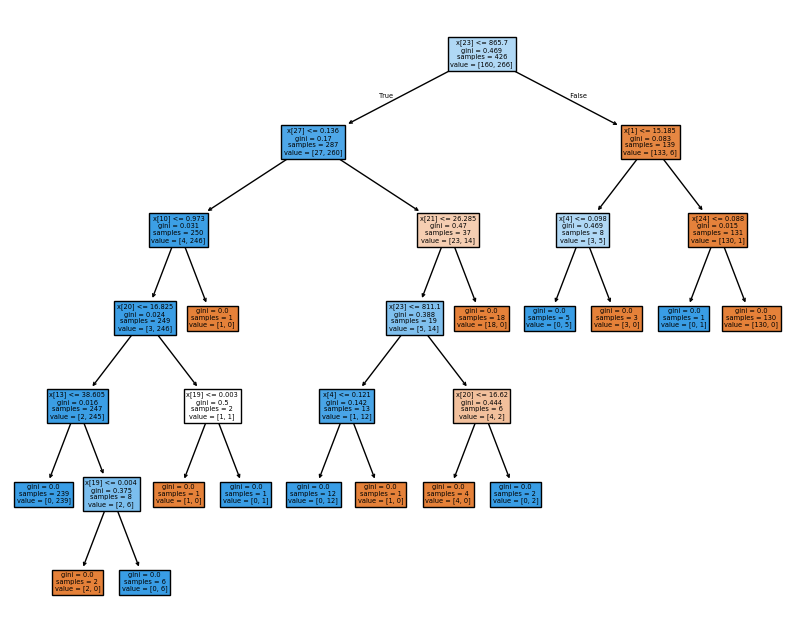

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
plt.figure(figsize = (10,8))
clf = DecisionTreeClassifier().fit(X_train, y_train)
plot_tree(clf, filled=True)
plt.show()

---
## Random Forest

Es, sin duda, uno de los algoritmos más populares, y de los más extendidos. Forma parte de los modelos conocidos como *ensemble learning*, que mezclan diversos algoritmos para obtener un mejor resultado. Los árboles de decisión son una técnica muy poderosa, pero que es fácilmente vulnerable, y este error se puede remediar con la técnica de *ensemble learning* conocida como *bagging*, donde se crean múltiples conjuntos de entrenamiento para ser entrenados en distintos árboles.

* Buscamos que los árboles de decisión sean lo más *incorrelados* posible, ya que la esperanza de una distribución de errores perfectamente distribuída es cero.

* La cantidad de *features* que elegiremos para entrenar en cada árbol debe ser reducida para asegurar la validez del argumetno anterior.

* Finalmente, las predicciones se combinan por media (caso continuo de regresión) o moda (caso discreto de clasificación).

In [6]:
#Librería necesaria
from statistics import mode

#Algoritmo RandomForest
class RandomForest():
    def __init__(self, n_trees=50, n_features='sqrt', n_samples=.5, depth=5, min_samples_split=2):
      #Asignamos resto de parámetros
      self.n_trees = n_trees
      self.n_features = n_features
      self.n_samples = n_samples
      self.depth = depth
      self.min_samples_split = min_samples_split

    def fit(self, X, y):
      #Definimos la cantidad de features que queremos tomar
      if self.n_features == 'sqrt':
          self.n_features = int(np.sqrt(X.shape[1]))
      elif self.n_features == 'log2':
          self.n_features = int(np.log2(X.shape[1]))
      else:
          pass
      #Aleatorizamos elección de filas y columnas, y entrenamos
      self.idxs = [
         np.random.choice(np.arange(X.shape[0]), size = int(X.shape[0]*self.n_samples), replace = False)
         for _ in np.arange(self.n_trees)
      ]
      self.cols = [
         np.random.choice(np.arange(X.shape[1]), size = self.n_features, replace = False)
         for _ in np.arange(self.n_trees)
      ]
      self.DTrees = []
      for tree in np.arange(self.n_trees):
        model = DecisionTree(self.min_samples_split, self.depth)
        self.DTrees.append(model)
        self.DTrees[tree].fit(X[self.idxs[tree],:][:,self.cols[tree]],y[self.idxs[tree]])

    def predict(self, X):
      y_pred = np.zeros((X.shape[0], self.n_trees))
      for col in np.arange(self.n_trees):
        y_pred[:,col] = self.DTrees[col].predict(X_test[:,self.cols[col]])
      y_pred = np.apply_along_axis(mode, 1, y_pred)
      return y_pred

In [7]:
RFC = RandomForest(
    n_trees=20,
    n_features='log2',
    n_samples=0.5,
    depth=10,
    min_samples_split=2,
)
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        52
           1       0.93      0.95      0.94        91

    accuracy                           0.92       143
   macro avg       0.92      0.91      0.92       143
weighted avg       0.92      0.92      0.92       143



# Extra: *Receiver Operating Characteristic*

Otra visión sobre las métricas de evaluación viene dada por la curva *Receiver Operating Characteristic* (ROC). En ella, podemos observar el ratio de comparación de verdaderos positivos con falsos positivos, y a menudo el área que encierra dicha curva con el eje de abscisas se toma como una métrica de calidad de modelos, conocida como *Area Under the Curve* (AUC).

Para llevar este cómputo a cabo, precisaremos utilizar una funcionalidad de los modelos que es el método **.predict_proba()**, que nos devuelve como su nombre indica la probabilidad de que un elemento pertenezca a una determinada clase.

Veamos primero el ejemplo binario:

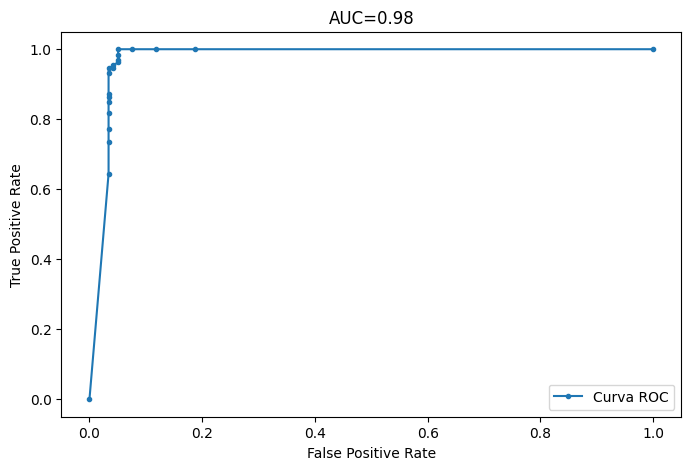

In [22]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#Generamos datos
X, y = make_classification(n_samples = 1000, n_features = 5, n_classes = 2)
#Dividimos en datos de entreno y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
#Entrenamos el modelo
model = RandomForestClassifier().fit(X_train, y_train)
#Elaboramos predicciones sobre los datos de validación
y_pred = model.predict_proba(X_test)[:,1]
#Inicializamos los vectores de probabilidades y false_positive_rate, true_positive_rate
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred)
RF_auc = roc_auc_score(y_test, y_pred)
# Dibujamos
plt.figure(figsize=(8,5))
plt.plot(RF_fpr, RF_tpr, marker='.', label='Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC={auc:.2f}'.format(auc=RF_auc))
plt.legend()
plt.show()